In [1]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Mounted at /gdrive
/gdrive


In [2]:
%cd My Drive
%cd Projectskripsi
%cd dataset

/gdrive/My Drive
/gdrive/My Drive/Projectskripsi
/gdrive/My Drive/Projectskripsi/dataset


In [3]:
!unzip ChestPneumonia.zip

Streaming output truncated to the last 5000 lines.
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0213-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0217-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0219-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0221-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0222-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0229-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0232-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0233-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0237-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0238-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0241-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0246-0001-0001.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0246-0001-0002.jpeg  
  inflating: ChestPneumonia/test/NORMAL/NORMAL2-IM-0246

In [4]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
import seaborn as sns
import keras
from keras.models import Sequential
from keras.models import Model
from keras.layers import Dense, Conv2D , MaxPool2D , Flatten , Dropout
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,confusion_matrix
import cv2
import os

In [5]:
labels = ['PNEUMONIA', 'NORMAL']
img_size = 128
def get_training_data(data_dir):
    data = []
    for label in labels:
        path = os.path.join(data_dir, label)
        class_num = labels.index(label)
        for img in os.listdir(path):
            try:
                img_arr = cv2.imread(os.path.join(path, img), cv2.IMREAD_GRAYSCALE)
                resized_arr = cv2.resize(img_arr, (img_size, img_size)) # Reshaping images to preferred size
                data.append([resized_arr, class_num])
            except Exception as e:
                print(e)
    return np.array(data)

In [6]:
train = get_training_data('ChestPneumonia/train')
test = get_training_data('ChestPneumonia/test')
val = get_training_data('ChestPneumonia/val')

<ipython-input-5-cef184a1da54>:15: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  return np.array(data)


<Axes: >

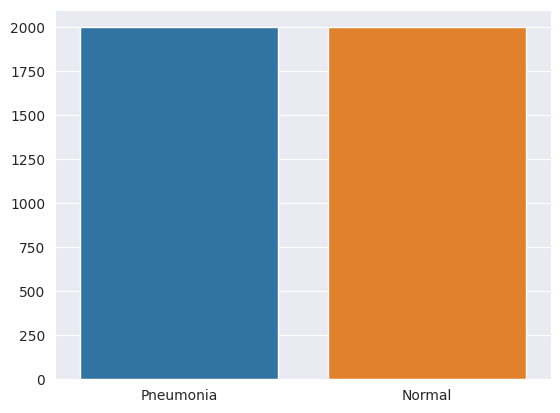

In [7]:
l = []
for i in train:
    if i[1] == 0:
        l.append("Pneumonia")
    else:
        l.append("Normal")

label_counts = pd.Series(l).value_counts()
sns.set_style('darkgrid')
sns.barplot(x=label_counts.index, y=label_counts.values)

Text(0.5, 1.0, 'NORMAL')

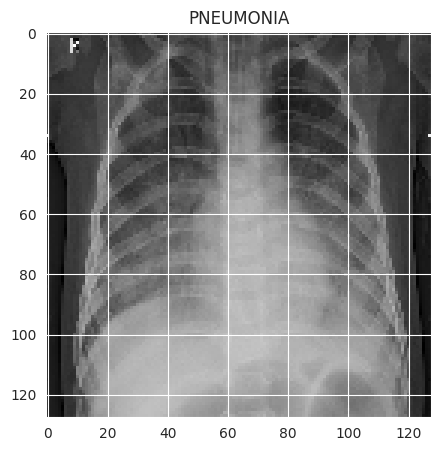

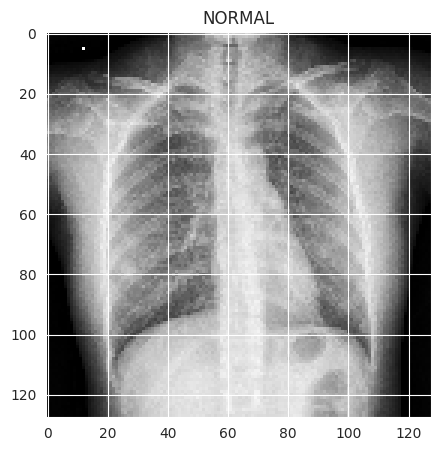

In [8]:
plt.figure(figsize = (5,5))
plt.imshow(train[0][0], cmap='gray')
plt.title(labels[train[0][1]])

plt.figure(figsize = (5,5))
plt.imshow(train[-1][0], cmap='gray')
plt.title(labels[train[-1][1]])

In [9]:
x_train = []
y_train = []

x_val = []
y_val = []

x_test = []
y_test = []

for feature, label in train:
    x_train.append(feature)
    y_train.append(label)

for feature, label in test:
    x_test.append(feature)
    y_test.append(label)

for feature, label in val:
    x_val.append(feature)
    y_val.append(label)

In [10]:
# Normalize the data
x_train = np.array(x_train) / 255
x_val = np.array(x_val) / 255
x_test = np.array(x_test) / 255

In [11]:
# resize data for deep learning
x_train = x_train.reshape(-1, img_size, img_size, 1)
y_train = np.array(y_train)

x_val = x_val.reshape(-1, img_size, img_size, 1)
y_val = np.array(y_val)

x_test = x_test.reshape(-1, img_size, img_size, 1)
y_test = np.array(y_test)

In [12]:
# With data augmentation to prevent overfitting and handling the imbalance in dataset

datagen = ImageDataGenerator(
        featurewise_center=False,  # set input mean to 0 over the dataset
        samplewise_center=False,  # set each sample mean to 0
        featurewise_std_normalization=False,  # divide inputs by std of the dataset
        samplewise_std_normalization=False,  # divide each input by its std
        zca_whitening=False,  # apply ZCA whitening
        rotation_range = 30,  # randomly rotate images in the range (degrees, 0 to 180)
        zoom_range = 0.2, # Randomly zoom image
        width_shift_range=0.1,  # randomly shift images horizontally (fraction of total width)
        height_shift_range=0.1,  # randomly shift images vertically (fraction of total height)
        horizontal_flip = False,  # randomly flip images
        vertical_flip=False)  # randomly flip images


datagen.fit(x_train)

In [13]:
#@title Default title text
model = Sequential()

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu' , input_shape = (128,128,1)))
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Conv2D(32 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 ))

model.add(Conv2D(64 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 ))

model.add(Conv2D(128 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2))

model.add(Conv2D(256 , (3,3) , strides = 1 , padding = 'same' , activation = 'relu'))
model.add(MaxPool2D((2,2) , strides = 2 ))

model.add(Flatten())
model.add(Dense(units = 128 , activation = 'relu'))
model.add(Dropout(0.2))
model.add(Dense(units = 1 , activation = 'sigmoid'))
model.compile(optimizer = 'adam' , loss = 'binary_crossentropy' , metrics = ['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 128, 128, 32)      320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 64, 64, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 64, 64, 32)        9248      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 32, 32, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 32, 32, 64)        18496     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 16, 16, 64)       0

In [14]:
#Percobaan ke-1
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
160/160 [==============================] - 25s 51ms/step - loss: 0.6192 - accuracy: 0.6570 - val_loss: 0.7396 - val_accuracy: 0.5667
Epoch 2/10
160/160 [==============================] - 9s 54ms/step - loss: 0.5075 - accuracy: 0.7607 - val_loss: 0.7474 - val_accuracy: 0.5700
Epoch 3/10
160/160 [==============================] - 7s 46ms/step - loss: 0.4720 - accuracy: 0.7722 - val_loss: 0.6264 - val_accuracy: 0.6167
Epoch 4/10
160/160 [==============================] - 9s 57ms/step - loss: 0.4591 - accuracy: 0.7807 - val_loss: 0.5894 - val_accuracy: 0.7133
Epoch 5/10
160/160 [==============================] - 9s 57ms/step - loss: 0.4096 - accuracy: 0.8188 - val_loss: 0.4683 - val_accuracy: 0.7933
Epoch 6/10
160/160 [==============================] - 7s 45ms/step - loss: 0.3516 - accuracy: 0.8508 - val_loss: 0.4142 - val_accuracy: 0.8000
Epoch 7/10
160/160 [==============================] - 9s 57ms/step - loss: 0.2551 - accuracy: 0.8885 - val_loss: 0.2809 - val_accuracy: 0.876

In [15]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 6ms/step - loss: 0.1343 - accuracy: 0.9470
Loss of the model is -  13.433115184307098 %
125/125 [==============================] - 1s 6ms/step - loss: 0.1343 - accuracy: 0.9470
Accuracy of the model is -  94.70000267028809 %


In [16]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 10ms/step - loss: 0.1907 - accuracy: 0.9310
Loss of the model is -  19.0743088722229 %
32/32 [==============================] - 0s 5ms/step - loss: 0.1907 - accuracy: 0.9310
Accuracy of the model is -  93.09999942779541 %


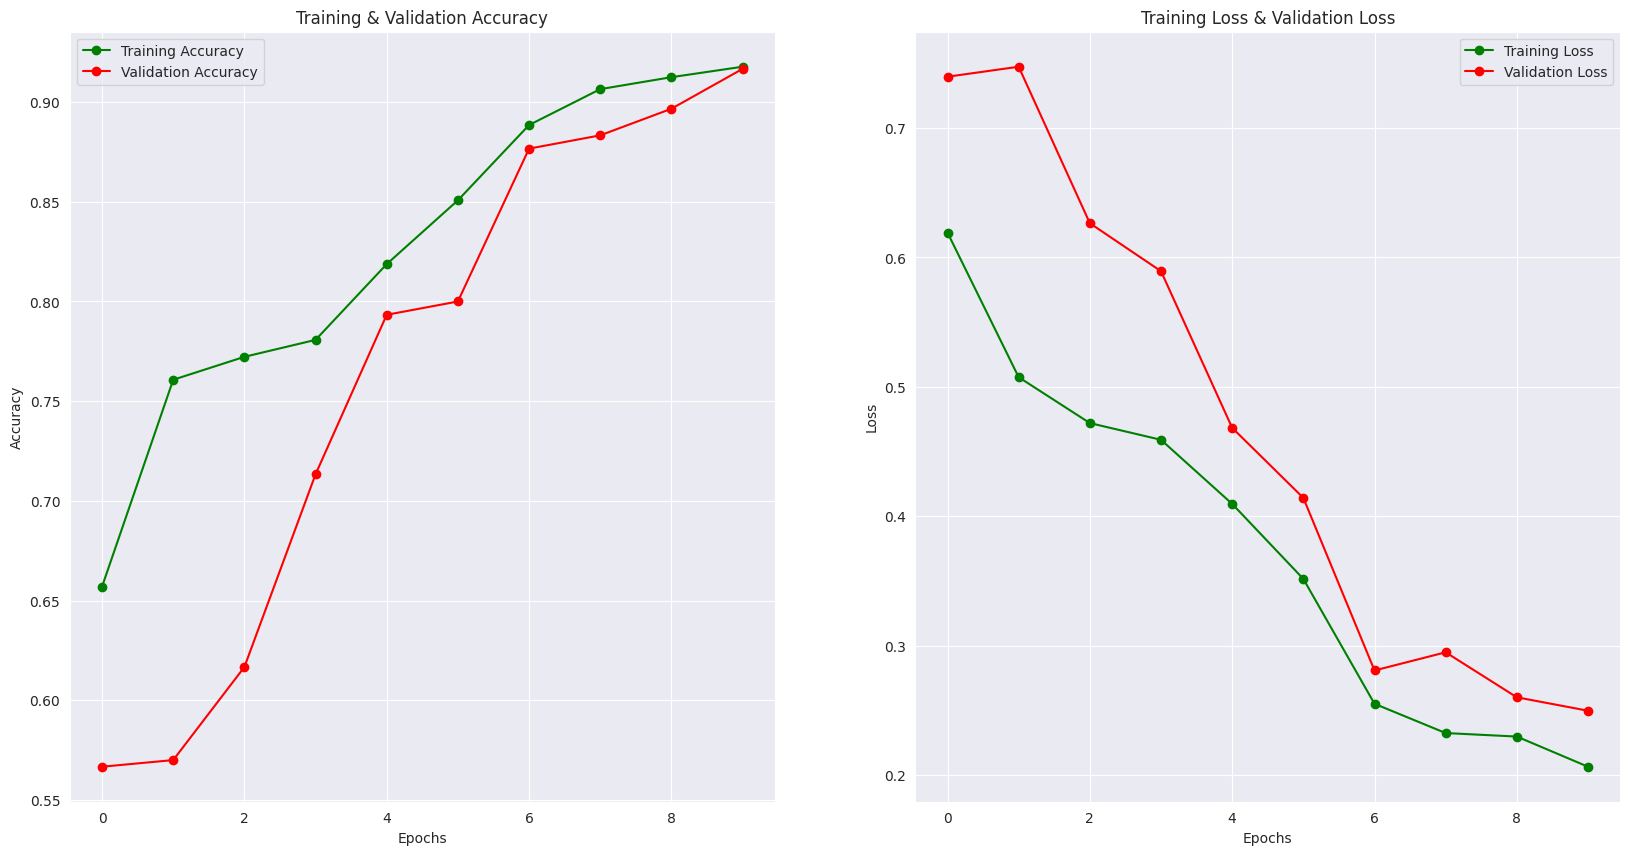

In [17]:
epochs = [i for i in range(10)]
fig , ax = plt.subplots(1,2)
train_acc = history.history['accuracy']
train_loss = history.history['loss']
val_acc = history.history['val_accuracy']
val_loss = history.history['val_loss']
fig.set_size_inches(20,10)

ax[0].plot(epochs , train_acc , 'go-' , label = 'Training Accuracy')
ax[0].plot(epochs , val_acc , 'ro-' , label = 'Validation Accuracy')
ax[0].set_title('Training & Validation Accuracy')
ax[0].legend()
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Accuracy")

ax[1].plot(epochs , train_loss , 'g-o' , label = 'Training Loss')
ax[1].plot(epochs , val_loss , 'r-o' , label = 'Validation Loss')
ax[1].set_title('Training Loss & Validation Loss')
ax[1].legend()
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Loss")
plt.show()

In [18]:
#Percobaan ke-2
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
160/160 [==============================] - 9s 53ms/step - loss: 0.1858 - accuracy: 0.9273 - val_loss: 0.2697 - val_accuracy: 0.8933
Epoch 2/20
160/160 [==============================] - 8s 48ms/step - loss: 0.1899 - accuracy: 0.9268 - val_loss: 0.2550 - val_accuracy: 0.9100
Epoch 3/20
160/160 [==============================] - 9s 59ms/step - loss: 0.1742 - accuracy: 0.9320 - val_loss: 0.2403 - val_accuracy: 0.9067
Epoch 4/20
160/160 [==============================] - 10s 64ms/step - loss: 0.1510 - accuracy: 0.9425 - val_loss: 0.1470 - val_accuracy: 0.9333
Epoch 5/20
160/160 [==============================] - 9s 58ms/step - loss: 0.1585 - accuracy: 0.9390 - val_loss: 0.2030 - val_accuracy: 0.9300
Epoch 6/20
160/160 [==============================] - 9s 54ms/step - loss: 0.1534 - accuracy: 0.9405 - val_loss: 0.1375 - val_accuracy: 0.9600
Epoch 7/20
160/160 [==============================] - 7s 47ms/step - loss: 0.1393 - accuracy: 0.9528 - val_loss: 0.1452 - val_accuracy: 0.953

In [19]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 8ms/step - loss: 0.0932 - accuracy: 0.9630
Loss of the model is -  9.32009369134903 %
125/125 [==============================] - 1s 8ms/step - loss: 0.0932 - accuracy: 0.9630
Accuracy of the model is -  96.29999995231628 %


In [20]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 10ms/step - loss: 0.1542 - accuracy: 0.9450
Loss of the model is -  15.419398248195648 %
32/32 [==============================] - 0s 9ms/step - loss: 0.1542 - accuracy: 0.9450
Accuracy of the model is -  94.49999928474426 %


In [21]:
#Percobaan ke-3
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/30
160/160 [==============================] - 8s 51ms/step - loss: 0.1156 - accuracy: 0.9555 - val_loss: 0.1059 - val_accuracy: 0.9567
Epoch 2/30
160/160 [==============================] - 9s 58ms/step - loss: 0.1114 - accuracy: 0.9605 - val_loss: 0.1072 - val_accuracy: 0.9767
Epoch 3/30
160/160 [==============================] - 8s 49ms/step - loss: 0.1117 - accuracy: 0.9592 - val_loss: 0.1308 - val_accuracy: 0.9600
Epoch 4/30
160/160 [==============================] - 8s 47ms/step - loss: 0.1179 - accuracy: 0.9563 - val_loss: 0.1422 - val_accuracy: 0.9500
Epoch 5/30
160/160 [==============================] - 10s 61ms/step - loss: 0.1070 - accuracy: 0.9635 - val_loss: 0.1416 - val_accuracy: 0.9400
Epoch 6/30
160/160 [==============================] - 8s 52ms/step - loss: 0.1093 - accuracy: 0.9580 - val_loss: 0.1572 - val_accuracy: 0.9333
Epoch 7/30
160/160 [==============================] - 7s 46ms/step - loss: 0.1093 - accuracy: 0.9592 - val_loss: 0.1067 - val_accuracy: 0.966

In [22]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 8ms/step - loss: 0.0731 - accuracy: 0.9700
Loss of the model is -  7.312119007110596 %
125/125 [==============================] - 1s 8ms/step - loss: 0.0731 - accuracy: 0.9700
Accuracy of the model is -  97.00000286102295 %


In [23]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 7ms/step - loss: 0.1457 - accuracy: 0.9510
Loss of the model is -  14.56955373287201 %
32/32 [==============================] - 0s 7ms/step - loss: 0.1457 - accuracy: 0.9510
Accuracy of the model is -  95.09999752044678 %


In [24]:
#Percobaan ke-4
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 40 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/40
160/160 [==============================] - 8s 47ms/step - loss: 0.0989 - accuracy: 0.9643 - val_loss: 0.1112 - val_accuracy: 0.9600
Epoch 2/40
160/160 [==============================] - 10s 60ms/step - loss: 0.0917 - accuracy: 0.9665 - val_loss: 0.0969 - val_accuracy: 0.9600
Epoch 3/40
160/160 [==============================] - 16s 97ms/step - loss: 0.0813 - accuracy: 0.9700 - val_loss: 0.0848 - val_accuracy: 0.9733
Epoch 4/40
160/160 [==============================] - 9s 59ms/step - loss: 0.0857 - accuracy: 0.9663 - val_loss: 0.1331 - val_accuracy: 0.9467
Epoch 5/40
160/160 [==============================] - 8s 53ms/step - loss: 0.0833 - accuracy: 0.9668 - val_loss: 0.1123 - val_accuracy: 0.9733
Epoch 6/40
160/160 [==============================] - 7s 46ms/step - loss: 0.0911 - accuracy: 0.9650 - val_loss: 0.1057 - val_accuracy: 0.9767
Epoch 7/40
160/160 [==============================] - 9s 59ms/step - loss: 0.0894 - accuracy: 0.9675 - val_loss: 0.1382 - val_accuracy: 0.95

In [25]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 9ms/step - loss: 0.0376 - accuracy: 0.9855
Loss of the model is -  3.7568986415863037 %
125/125 [==============================] - 1s 7ms/step - loss: 0.0376 - accuracy: 0.9855
Accuracy of the model is -  98.54999780654907 %


In [26]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 7ms/step - loss: 0.1297 - accuracy: 0.9490
Loss of the model is -  12.972278892993927 %
32/32 [==============================] - 0s 7ms/step - loss: 0.1297 - accuracy: 0.9490
Accuracy of the model is -  94.90000009536743 %


In [27]:
#Percobaan ke-5
history = model.fit(datagen.flow(x_train,y_train, batch_size = 25) ,epochs = 50 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/50
160/160 [==============================] - 7s 43ms/step - loss: 0.0732 - accuracy: 0.9750 - val_loss: 0.0618 - val_accuracy: 0.9800
Epoch 2/50
160/160 [==============================] - 9s 55ms/step - loss: 0.0590 - accuracy: 0.9768 - val_loss: 0.0532 - val_accuracy: 0.9867
Epoch 3/50
160/160 [==============================] - 9s 57ms/step - loss: 0.0679 - accuracy: 0.9750 - val_loss: 0.2190 - val_accuracy: 0.9500
Epoch 4/50
160/160 [==============================] - 7s 46ms/step - loss: 0.0636 - accuracy: 0.9772 - val_loss: 0.0905 - val_accuracy: 0.9733
Epoch 5/50
160/160 [==============================] - 8s 51ms/step - loss: 0.0619 - accuracy: 0.9768 - val_loss: 0.0985 - val_accuracy: 0.9600
Epoch 6/50
160/160 [==============================] - 9s 58ms/step - loss: 0.0700 - accuracy: 0.9730 - val_loss: 0.1223 - val_accuracy: 0.9667
Epoch 7/50
160/160 [==============================] - 7s 46ms/step - loss: 0.0634 - accuracy: 0.9772 - val_loss: 0.0966 - val_accuracy: 0.9700

In [28]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 7ms/step - loss: 0.0295 - accuracy: 0.9877
Loss of the model is -  2.948845364153385 %
125/125 [==============================] - 1s 6ms/step - loss: 0.0295 - accuracy: 0.9877
Accuracy of the model is -  98.7749993801117 %


In [29]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 7ms/step - loss: 0.1441 - accuracy: 0.9550
Loss of the model is -  14.409308135509491 %
32/32 [==============================] - 0s 6ms/step - loss: 0.1441 - accuracy: 0.9550
Accuracy of the model is -  95.49999833106995 %


In [30]:
#Percobaan ke-6
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 10 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/10
80/80 [==============================] - 10s 112ms/step - loss: 0.0467 - accuracy: 0.9833 - val_loss: 0.0652 - val_accuracy: 0.9833
Epoch 2/10
80/80 [==============================] - 8s 102ms/step - loss: 0.0417 - accuracy: 0.9858 - val_loss: 0.0711 - val_accuracy: 0.9767
Epoch 3/10
80/80 [==============================] - 8s 94ms/step - loss: 0.0405 - accuracy: 0.9847 - val_loss: 0.1005 - val_accuracy: 0.9833
Epoch 4/10
80/80 [==============================] - 8s 106ms/step - loss: 0.0358 - accuracy: 0.9862 - val_loss: 0.1252 - val_accuracy: 0.9667
Epoch 5/10
80/80 [==============================] - 7s 84ms/step - loss: 0.0417 - accuracy: 0.9850 - val_loss: 0.0975 - val_accuracy: 0.9767
Epoch 6/10
80/80 [==============================] - 9s 106ms/step - loss: 0.0420 - accuracy: 0.9840 - val_loss: 0.0963 - val_accuracy: 0.9700
Epoch 7/10
80/80 [==============================] - 8s 99ms/step - loss: 0.0411 - accuracy: 0.9835 - val_loss: 0.0922 - val_accuracy: 0.9733
Epoch 8/

In [31]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 7ms/step - loss: 0.0168 - accuracy: 0.9940
Loss of the model is -  1.683352142572403 %
125/125 [==============================] - 1s 7ms/step - loss: 0.0168 - accuracy: 0.9940
Accuracy of the model is -  99.40000176429749 %


In [32]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 6ms/step - loss: 0.1691 - accuracy: 0.9620
Loss of the model is -  16.90598577260971 %
32/32 [==============================] - 0s 6ms/step - loss: 0.1691 - accuracy: 0.9620
Accuracy of the model is -  96.20000123977661 %


In [33]:
#Percobaan ke-7
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 20 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/20
80/80 [==============================] - 8s 101ms/step - loss: 0.0470 - accuracy: 0.9820 - val_loss: 0.1484 - val_accuracy: 0.9567
Epoch 2/20
80/80 [==============================] - 7s 86ms/step - loss: 0.0408 - accuracy: 0.9835 - val_loss: 0.0965 - val_accuracy: 0.9733
Epoch 3/20
80/80 [==============================] - 8s 102ms/step - loss: 0.0352 - accuracy: 0.9875 - val_loss: 0.0731 - val_accuracy: 0.9767
Epoch 4/20
80/80 [==============================] - 9s 115ms/step - loss: 0.0436 - accuracy: 0.9815 - val_loss: 0.1127 - val_accuracy: 0.9700
Epoch 5/20
80/80 [==============================] - 7s 85ms/step - loss: 0.0471 - accuracy: 0.9822 - val_loss: 0.0664 - val_accuracy: 0.9767
Epoch 6/20
80/80 [==============================] - 9s 109ms/step - loss: 0.0420 - accuracy: 0.9855 - val_loss: 0.1098 - val_accuracy: 0.9667
Epoch 7/20
80/80 [==============================] - 7s 85ms/step - loss: 0.0367 - accuracy: 0.9847 - val_loss: 0.1181 - val_accuracy: 0.9700
Epoch 8/2

In [34]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 6ms/step - loss: 0.0201 - accuracy: 0.9930
Loss of the model is -  2.0103489980101585 %
125/125 [==============================] - 1s 6ms/step - loss: 0.0201 - accuracy: 0.9930
Accuracy of the model is -  99.29999709129333 %


In [35]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 5ms/step - loss: 0.1641 - accuracy: 0.9590
Loss of the model is -  16.41474962234497 %
32/32 [==============================] - 0s 5ms/step - loss: 0.1641 - accuracy: 0.9590
Accuracy of the model is -  95.89999914169312 %


In [36]:
#Percobaan ke-8
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 30 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/30
80/80 [==============================] - 9s 108ms/step - loss: 0.0405 - accuracy: 0.9860 - val_loss: 0.0971 - val_accuracy: 0.9700
Epoch 2/30
80/80 [==============================] - 7s 85ms/step - loss: 0.0422 - accuracy: 0.9833 - val_loss: 0.0845 - val_accuracy: 0.9700
Epoch 3/30
80/80 [==============================] - 9s 108ms/step - loss: 0.0364 - accuracy: 0.9852 - val_loss: 0.1392 - val_accuracy: 0.9733
Epoch 4/30
80/80 [==============================] - 7s 85ms/step - loss: 0.0402 - accuracy: 0.9852 - val_loss: 0.1109 - val_accuracy: 0.9533
Epoch 5/30
80/80 [==============================] - 9s 109ms/step - loss: 0.0446 - accuracy: 0.9840 - val_loss: 0.0695 - val_accuracy: 0.9767
Epoch 6/30
80/80 [==============================] - 8s 97ms/step - loss: 0.0396 - accuracy: 0.9852 - val_loss: 0.0767 - val_accuracy: 0.9767
Epoch 7/30
80/80 [==============================] - 8s 99ms/step - loss: 0.0386 - accuracy: 0.9855 - val_loss: 0.0739 - val_accuracy: 0.9733
Epoch 8/30

In [37]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 6ms/step - loss: 0.0381 - accuracy: 0.9870
Loss of the model is -  3.8067512214183807 %
125/125 [==============================] - 1s 5ms/step - loss: 0.0381 - accuracy: 0.9870
Accuracy of the model is -  98.69999885559082 %


In [38]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 6ms/step - loss: 0.1927 - accuracy: 0.9580
Loss of the model is -  19.270451366901398 %
32/32 [==============================] - 0s 6ms/step - loss: 0.1927 - accuracy: 0.9580
Accuracy of the model is -  95.80000042915344 %


In [39]:
#Percobaan ke-9
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 40 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/40
80/80 [==============================] - 8s 104ms/step - loss: 0.0314 - accuracy: 0.9908 - val_loss: 0.1001 - val_accuracy: 0.9667
Epoch 2/40
80/80 [==============================] - 7s 81ms/step - loss: 0.0365 - accuracy: 0.9868 - val_loss: 0.0714 - val_accuracy: 0.9733
Epoch 3/40
80/80 [==============================] - 8s 102ms/step - loss: 0.0335 - accuracy: 0.9875 - val_loss: 0.1077 - val_accuracy: 0.9800
Epoch 4/40
80/80 [==============================] - 7s 82ms/step - loss: 0.0393 - accuracy: 0.9858 - val_loss: 0.0487 - val_accuracy: 0.9800
Epoch 5/40
80/80 [==============================] - 8s 102ms/step - loss: 0.0330 - accuracy: 0.9858 - val_loss: 0.0637 - val_accuracy: 0.9667
Epoch 6/40
80/80 [==============================] - 7s 85ms/step - loss: 0.0320 - accuracy: 0.9870 - val_loss: 0.0757 - val_accuracy: 0.9800
Epoch 7/40
80/80 [==============================] - 7s 81ms/step - loss: 0.0248 - accuracy: 0.9908 - val_loss: 0.0989 - val_accuracy: 0.9700
Epoch 8/40

In [40]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.9970
Loss of the model is -  1.0078526102006435 %
125/125 [==============================] - 1s 6ms/step - loss: 0.0101 - accuracy: 0.9970
Accuracy of the model is -  99.6999979019165 %


In [41]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 5ms/step - loss: 0.1706 - accuracy: 0.9670
Loss of the model is -  17.0558363199234 %
32/32 [==============================] - 0s 6ms/step - loss: 0.1706 - accuracy: 0.9670
Accuracy of the model is -  96.70000076293945 %


In [42]:
#Percobaan ke-10
history = model.fit(datagen.flow(x_train,y_train, batch_size = 50) ,epochs = 50 , validation_data = datagen.flow(x_val, y_val))

Epoch 1/50
80/80 [==============================] - 9s 112ms/step - loss: 0.0324 - accuracy: 0.9860 - val_loss: 0.0567 - val_accuracy: 0.9700
Epoch 2/50
80/80 [==============================] - 7s 85ms/step - loss: 0.0363 - accuracy: 0.9877 - val_loss: 0.0508 - val_accuracy: 0.9800
Epoch 3/50
80/80 [==============================] - 8s 93ms/step - loss: 0.0384 - accuracy: 0.9835 - val_loss: 0.1257 - val_accuracy: 0.9567
Epoch 4/50
80/80 [==============================] - 9s 107ms/step - loss: 0.0265 - accuracy: 0.9902 - val_loss: 0.0789 - val_accuracy: 0.9767
Epoch 5/50
80/80 [==============================] - 7s 85ms/step - loss: 0.0258 - accuracy: 0.9920 - val_loss: 0.0697 - val_accuracy: 0.9833
Epoch 6/50
80/80 [==============================] - 8s 105ms/step - loss: 0.0304 - accuracy: 0.9895 - val_loss: 0.1166 - val_accuracy: 0.9733
Epoch 7/50
80/80 [==============================] - 7s 86ms/step - loss: 0.0315 - accuracy: 0.9870 - val_loss: 0.1610 - val_accuracy: 0.9567
Epoch 8/50

In [43]:
print("Loss of the model is - " , model.evaluate(x_train,y_train)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_train,y_train)[1]*100 , "%")

125/125 [==============================] - 1s 8ms/step - loss: 0.0125 - accuracy: 0.9952
Loss of the model is -  1.2505274266004562 %
125/125 [==============================] - 1s 7ms/step - loss: 0.0125 - accuracy: 0.9952
Accuracy of the model is -  99.52499866485596 %


In [44]:
print("Loss of the model is - " , model.evaluate(x_test,y_test)[0]*100 , "%")
print("Accuracy of the model is - " , model.evaluate(x_test,y_test)[1]*100 , "%")

32/32 [==============================] - 0s 6ms/step - loss: 0.1573 - accuracy: 0.9700
Loss of the model is -  15.731841325759888 %
32/32 [==============================] - 0s 6ms/step - loss: 0.1573 - accuracy: 0.9700
Accuracy of the model is -  97.00000286102295 %


In [45]:
predictions = (model.predict(x_test) > 0.5).astype("int32")
predictions = predictions.reshape(1,-1)[0]
predictions[:100]


32/32 [==============================] - 0s 4ms/step


array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=int32)

In [46]:
print(classification_report(y_test, predictions, target_names = ['Pneumonia','Normal']))

              precision    recall  f1-score   support

   Pneumonia       0.98      0.96      0.97       500
      Normal       0.96      0.98      0.97       500

    accuracy                           0.97      1000
   macro avg       0.97      0.97      0.97      1000
weighted avg       0.97      0.97      0.97      1000



In [47]:
cm = confusion_matrix(y_test,predictions)
cm

array([[479,  21],
       [  9, 491]])

In [48]:
cm = pd.DataFrame(cm , index = ['0','1'] , columns = ['0','1'])

<Axes: >

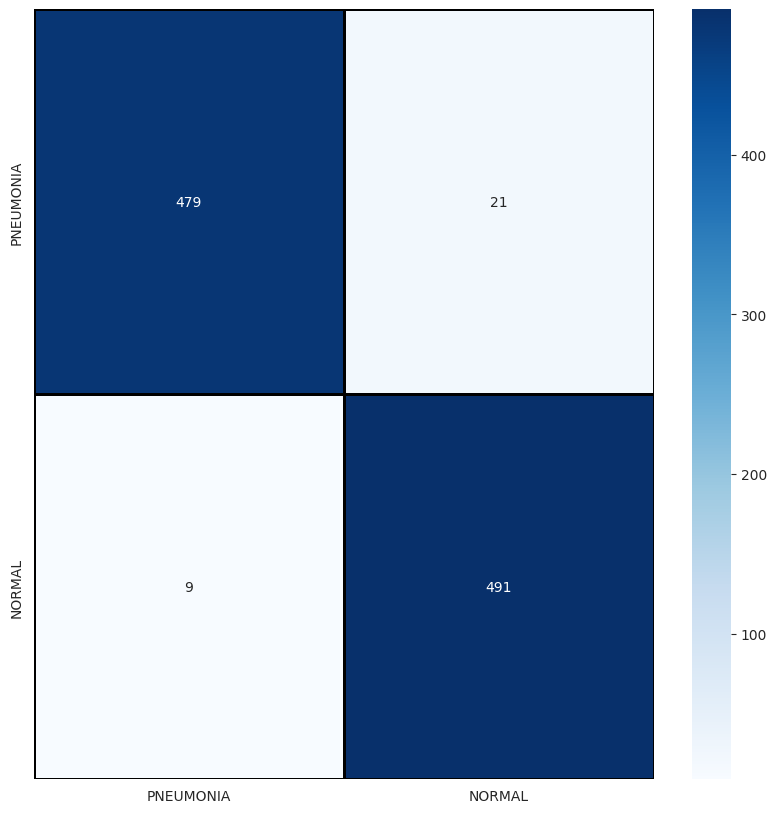

In [49]:
plt.figure(figsize = (10,10))
sns.heatmap(cm,cmap= "Blues", linecolor = 'black' , linewidth = 1 , annot = True, fmt='',xticklabels = labels,yticklabels = labels)

In [50]:
correct = np.nonzero(predictions == y_test)[0]
incorrect = np.nonzero(predictions != y_test)[0]

<ipython-input-51-4fe8ec2b3759>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


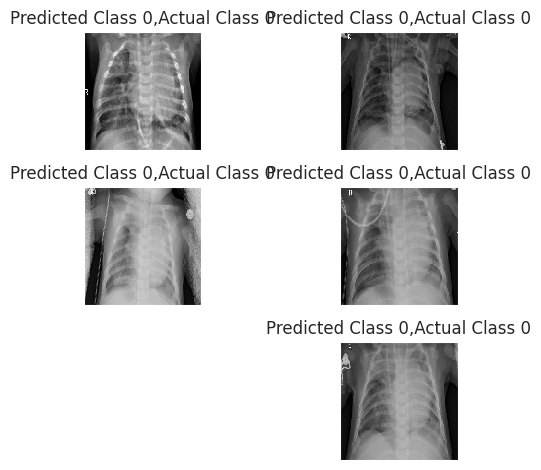

In [51]:
i = 0
for c in correct[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(128,128), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1



<ipython-input-52-3f78469589f1>:3: MatplotlibDeprecationWarning: Auto-removal of overlapping axes is deprecated since 3.6 and will be removed two minor releases later; explicitly call ax.remove() as needed.
  plt.subplot(3,2,i+1)


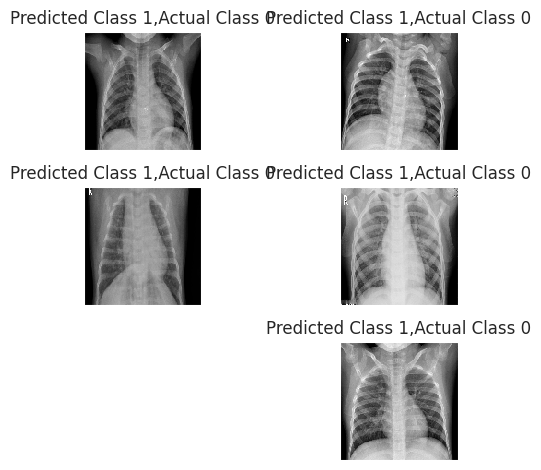

In [52]:
i = 0
for c in incorrect[:6]:
    plt.subplot(3,2,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.imshow(x_test[c].reshape(128,128), cmap="gray", interpolation='none')
    plt.title("Predicted Class {},Actual Class {}".format(predictions[c], y_test[c]))
    plt.tight_layout()
    i += 1

